#Neural Style Transfer with Tensorflow 2.0


Neural Style transfer is a process by which a semi trained convolutional neural network is used to transfer the stylistic details of one image and render another image with the learned styles. The process involves two images - a content image on which the style is imposed and a style image from which the style is copied. The idea of the neural style transfer algorithm was introduced in the paper [A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf), by Gatys et al.

We start by importing all the necessary libraries. We use VGG19 
model's pretrained weights to help simplify the process, and avoid training a whole image classifier. We'll use `time` to initialize our seed randomly and to evaluate the speed of the model. We will use `matplotlib.pyplot` and `PIL` for our images.

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import time
import PIL.Image

np.random.seed(int(time.time()))
%matplotlib inline

We write a small helper function to convert the tensor produced by the model into an image which can be viewed by us.

In [22]:
def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

We will now resize and process the image for TensorFlow's purposes to make it uniformly sized. It would therefore help to provide images which are already clean. Let's also plot the images for a quick look before running them on the algorithm. The files here are stored locally on the Google Drive, but the path can be changed to the directory where your image files are. You can even choose to skip the below step if your images are stored at a URL, which you can modify appropriately in the path variables. You will however need to make sure that your images are of the shape `[None, dim, dim, 3]` after loading them, where `dim` would the value of the variable which you can modify. Do note that obviously for a larger image, it would take more time to generate.

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


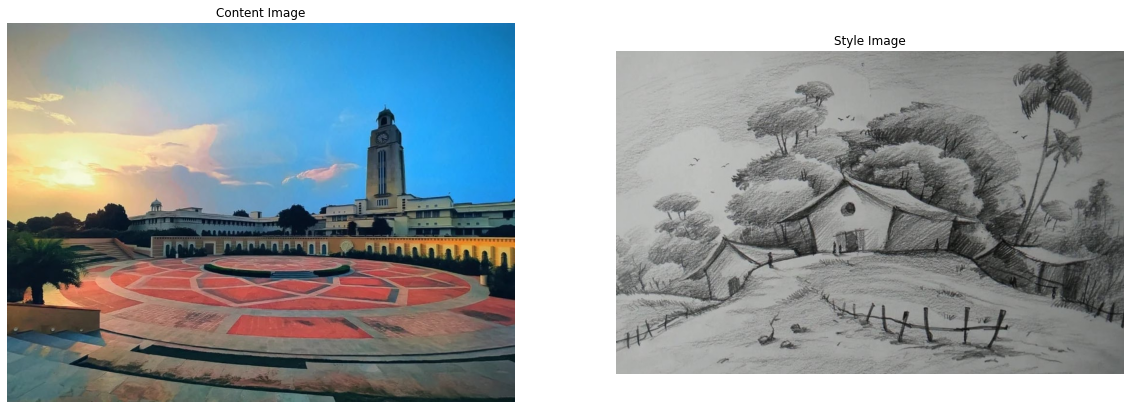

In [24]:
content_path = '/content/drive/My Drive/-/Neural Style Transfer/Images/rotunda.jpg'
style_path = '/content/drive/My Drive/-/Neural Style Transfer/Images/styles/pencil.jpg'

content = plt.imread(content_path)
style = plt.imread(style_path)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(content)
ax1.set_title('Content Image')
ax1.set_axis_off()
ax2.imshow(style)
ax2.set_title('Style Image')
ax2.set_axis_off()
plt.show()

In [25]:
def load_image(image):
  dim = 300
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [dim, dim])
  img = img[tf.newaxis, :]
  return img

In [26]:
content = load_image(content_path)
style = load_image(style_path)

Here, we use the [VGG19 model](https://arxiv.org/pdf/1409.1556.pdf). It was a runner up in the 2014 ImageNet challenge, and we take the pretrained weights to reuse them again. We extract features from the original and the style image with this. At the second layer from the fourth convolution block, we extract the original image features. Here we stop and calculate the content loss to find out how much content from the original image we lose. Similarly for the style loss, the paper advises the extraction of representations from five layers - the first layer from the first five convolutional blocks. So we pull out only the layers we need from the VGG architechture, and run forward passes on it to get our features. Experiment with the layers used.

In [27]:
content_layers = [#'block1_conv2',
                  #'block2_conv2',
                  #'block3_conv2',
                  'block4_conv2',
                  #'block5_conv2'
                  ]

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
                ]


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [28]:
vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg_model.trainable = False

In [29]:
def custom_vgg_model(layer_names, model):
  outputs = [model.get_layer(name).output for name in layer_names]
  model = Model([vgg_model.input], outputs)
  return model

From the multiple layer for the style image, we make a "gram matrix". This would help us determine how similar the features are within a single layer, and also help in learning a arbitrary non localized features. For the gram matrix, we simply take a convoluted image, of say $m \times n \times f$, where $f$ is the number of feature maps, then we simple reshape it into a matrix of shape $f \times mn$ and multiply it with its transpose. This gives us a matrix of the form $f \times f$ which will be our gram matrix. Finally, we complete the modification and build a custom model to do our style transfer.

In [30]:
def gram_matrix(tensor):
  temp = tensor
  temp = tf.squeeze(temp)
  fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
  result = tf.matmul(temp, temp, transpose_b=True)
  gram = tf.expand_dims(result, axis=0)
  return gram

In [31]:
class Style_Model(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(Style_Model, self).__init__()
    self.vgg =  custom_vgg_model(style_layers + content_layers, vgg_model)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [32]:
extractor = Style_Model(style_layers, content_layers)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

The last piece of the jigsaw puzzle is actually calculating the loss for the model. The content loss can be simply calculated as follows, considering $T$ as the target image and $C$ as the original content image.
$$L_{content} = \frac{1}{2} \sum (T - C) ^2$$
The style loss is calculated as follows, with $T$ again being the target image and $S$ being the style image. As we extract from multiple layers, we iterate through $i$ while summing. $a$ is a small constant and $w_i$ is the tiny weights to give importance to each layer considered.
$$L_{style} = a \sum_i w_i (T_i - S_i)^2$$
The total loss is hence put together as follows, with $\alpha$, the content weight, and $\beta$, the overall style weight, as hyperparameters.
$$L = \alpha L_{content} + \beta L_{style}$$
The values of the variables in the code block below can be modified to experiment with the various outputs.

In [33]:
style_weight = 2e-5
content_weight = 5e5

style_weights = {'block1_conv1': 1,
                 'block2_conv1': 2,
                 'block3_conv1': 7,
                 'block4_conv1': 1,
                 'block5_conv1': 4}

To deal with the various high frequency artifacts in the image, we can include a regularization term which will decrease their influence, and this is called the variational loss. 

In [34]:
total_variation_weight=10

In [41]:
def total_loss(outputs, image):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    variational_loss = total_variation_weight*tf.image.total_variation(image)

    loss = style_loss + content_loss + variational_loss
    return loss

Finally, we put it all together and train the model with the Adam optimizer in tensorflow with a learning rate of 0.02. We also decorate the image train step with the [`tf.function`](https://www.tensorflow.org/guide/function) decorator, which will massively speed up the running time for our algorithm. We assign the output image to a TensorFlow variable. We then run the model for some epochs, and make it show the image at the end of every epoch. We let each epoch run for a variable number of steps, and these are hyperparameters which can be modified.

In [42]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [43]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = total_loss(outputs, image) 

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [44]:
target_image = tf.Variable(content)

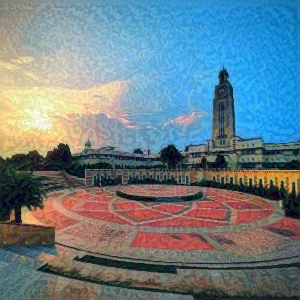

In [45]:
train_step(target_image)
train_step(target_image)
train_step(target_image)
tensor_to_image(target_image)

In [46]:
target_image = tf.Variable(content)
epochs = 4
steps_per_epoch = 50

step = 0
outputs = []

for n in range(epochs):
  Tic = time.time()
  for m in range(steps_per_epoch):
    train_step(target_image)
    step += 1
  Toc = time.time()
  print("Epoch " + str(n+1) + " took " + str(Toc-Tic) + " sec(s)")
  
  outputs.append(tensor_to_image(target_image))

Epoch 1 took 5.024715900421143 sec(s)
Epoch 2 took 4.921209812164307 sec(s)
Epoch 3 took 4.93729567527771 sec(s)
Epoch 4 took 4.958149433135986 sec(s)


Finally, a small bit of code to either view a sample of the images produced, or just the end product and an option to download them.

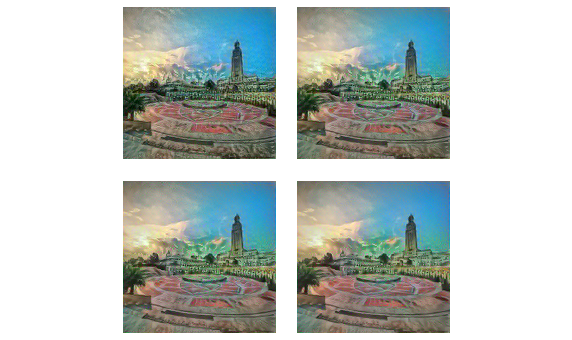

In [47]:
fig = plt.figure(figsize=(10, 6))
plt.axis('off')

grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),
                 axes_pad=0.3,
                 )

for ax, im in zip(grid, outputs):
    ax.imshow(im)
    ax.set_axis_off()

plt.show()

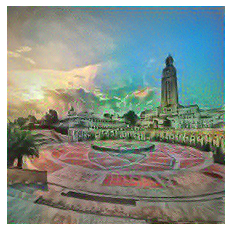

In [48]:
finalimg = plt.figure()
plt.axis('off')
plt.imshow(outputs[-1])
plt.show()

In [49]:
from google.colab import files
file_name1 = content_path[content_path.rfind('/')+1:]
file_name2 = style_path[style_path.rfind('/')+1:]
file_name_stub = file_name1[:-4] + '-' + file_name2[:-4]
file_name_stub = file_name_stub.replace(' ', '-')

In [ ]:
file_name = file_name_stub + '.png'
finalimg.savefig(file_name)
files.download(file_name)

After a frustrating hyperparameter search, the easy way out is in the below code cell. We use `tensorflow_hub`'s inbuilt neural style transfer mechanism. `tensorflow_hub` is a library with many reusable machine learning models.

In [ ]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content), tf.constant(style))[0]
img = tensor_to_image(stylized_image)
file_name = file_name_stub + '.png'
img.save(file_name)
files.download(file_name)